# Predicting COVID-19 Case Counts 
##### Forecast cases by US county
##### Use an LSTM neural network model

### Import packages

In [220]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,10)

### Read in the case count data
##### From the dataworld website
##### Saved locally as "data/Johns Hopkins COVID-19 Cases.csv"
##### https://data.world/covid-19-data-resource-hub/covid-19-case-counts

In [399]:
data = pd.read_csv("data/Johns Hopkins COVID-19 Cases.csv")
data.Date = pd.to_datetime(data.Date)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Restrict the data to the US
##### This dataset contains entries for many countries and is interesting to play around with

In [400]:
data = data[data.Country_Region=="US"]

### Keep only the positive case counts
##### The LSTM network does not train well when there are many mostly-zero sequences

In [404]:
data = data[data.Cases > 0]

### Split off case counts and deaths
##### The remaining analysis focuses on cases only but is easily adapted

In [405]:
cases = data[data.Case_Type=="Confirmed"]
deaths = data[data.Case_Type=="Deaths"]

### Create sequences from the data

##### Parameters

In [406]:
sequence_length = 5

##### Utility function

In [407]:
def sequence_data(df,sequence_length,col="Cases"):
    values = df[col]
    
    sequences = []
    targets = []
    
    for k in range(0,len(values)-sequence_length): #Populate return values with slicing operations
        sequences.append(values.iloc[k:k+sequence_length].values)
        targets.append(values.iloc[k+sequence_length])
        
    return sequences,targets

##### Loop through the counties and append their sequences and targets together

In [409]:
#Containers for training data and targets
sequences_array = np.array([])
targets_array = np.array([])
id_list = []

#Consider each consumer in turn and create sequences and targets
for fips in cases.FIPS.unique():

    #Raw values as np.array
    subset = cases[cases.FIPS==fips]
    subset.sort_values("Date",inplace=True)

    #Create sequences and targets
    sequences_addition, targets_addition = sequence_data(subset,sequence_length)
    if not sequences_addition:
        continue

    #Append to the containers
    if len(sequences_array) > 0:
        sequences_array = np.vstack((sequences_array,sequences_addition))
        targets_array += targets_addition
    else:
        sequences_array = sequences_addition
        targets_array = targets_addition

    id_list = id_list + [fips] * len(sequences_addition)

#Convert the results to numpy arrays
sequences_array = np.array(sequences_array)
targets_array = np.array(targets_array)

sequences = np.array(sequences_array).reshape((-1,sequence_length,1))
targets = targets_array

##### Filter out the sequences with small case counts

In [412]:
min_cases = 10

totals = sequences.sum(axis=1)
idx_array = np.argwhere(totals > min_cases*sequence_length)
idx_array = [x[0] for x in idx_array]

sequences = sequences[idx_array]
targets = targets[idx_array]
id_list = np.array(id_list)[idx_array]

### Set aside some of the data for testing

In [442]:
test_ratio = 0.1

cutoff = round((1-test_ratio)*len(targets))

sequences_train = sequences[:cutoff]
sequences_test = sequences[cutoff:]

targets_train = targets[:cutoff]
targets_test = targets[cutoff:]

# Build the LSTM model

In [443]:
from keras.models import Sequential

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Dropout
from keras.regularizers import l1, l2, l1_l2

from sklearn.preprocessing import MinMaxScaler

### Scale the data

In [446]:
scaling_factor = targets.max()

sequences_train_scaled = sequences_train/scaling_factor
sequences_test_scaled = sequences_test/scaling_factor

targets_train_scaled = targets_train/scaling_factor
targets_test_scaled = targets_test/scaling_factor

### Set parameters for LSTM network

In [447]:
width = 1
depth = sequence_length

### Develop the model

In [448]:
node_size=16
second_layer=0
optimizer="adam"
loss="mean_squared_error"
activation="relu"

model = Sequential()
if not second_layer:
    model.add(LSTM(node_size, input_shape=(depth, width)))
else:
    model.add(LSTM(node_size, input_shape=(depth, width), return_sequences=True))
    model.add(LSTM(node_size))

model.add(Dense(width))
model.add(Activation(activation))

model.compile(loss=loss,optimizer=optimizer)

### Fit the model

In [508]:
model.fit(sequences_train_scaled,targets_train_scaled,batch_size=16,epochs=10,verbose=2)

Epoch 1/10
 - 0s - loss: 8.6758e-04
Epoch 2/10
 - 0s - loss: 8.5693e-04
Epoch 3/10
 - 0s - loss: 8.3521e-04
Epoch 4/10
 - 0s - loss: 8.1148e-04
Epoch 5/10
 - 0s - loss: 8.1799e-04
Epoch 6/10
 - 0s - loss: 8.2114e-04
Epoch 7/10
 - 0s - loss: 8.1429e-04
Epoch 8/10
 - 0s - loss: 8.0256e-04
Epoch 9/10
 - 0s - loss: 7.9622e-04
Epoch 10/10
 - 0s - loss: 7.9289e-04


### Calculate the mean absolute error for next-day predictions

In [560]:
predictions_scaled = model.predict(sequences_test_scaled)
predictions = [np.round(x*scaling_factor) for x in predictions_scaled]

differences = [abs(predictions[k]/targets_test[k]-1) for k in range(len(predictions))]
mape = sum(differences)/len(predictions)

print("Mean absolute error: {:.4}%".format(100*mape[0]))

Mean absolute error: 1.212%


### Step through the prediction one day at a time

In [511]:
start_index = 0
end_index = len(sequences_test_scaled)

sequences_test_scaled_subset = sequences_test_scaled[start_index:end_index].copy()

input_sequence = sequences_test_scaled_subset[0].reshape((-1,sequence_length,1))

next_value = model.predict(input_sequence)

predictions_scaled = [next_value[0][0]]

input_sequence[:,:-1,:] = input_sequence[:,1:,:]
input_sequence[:,-1,:] = next_value

for _ in range(len(sequences_test_scaled_subset)-1):
    next_value = model.predict(input_sequence)

    predictions_scaled.append(next_value[0][0])

    input_sequence[:,:-1,:] = input_sequence[:,1:,:]
    input_sequence[:,-1,:] = next_value
    
predictions = [predictions_scaled[k]*scaling_factor for k in range(len(predictions_scaled))]

### Plot the difference between the predicted and actual

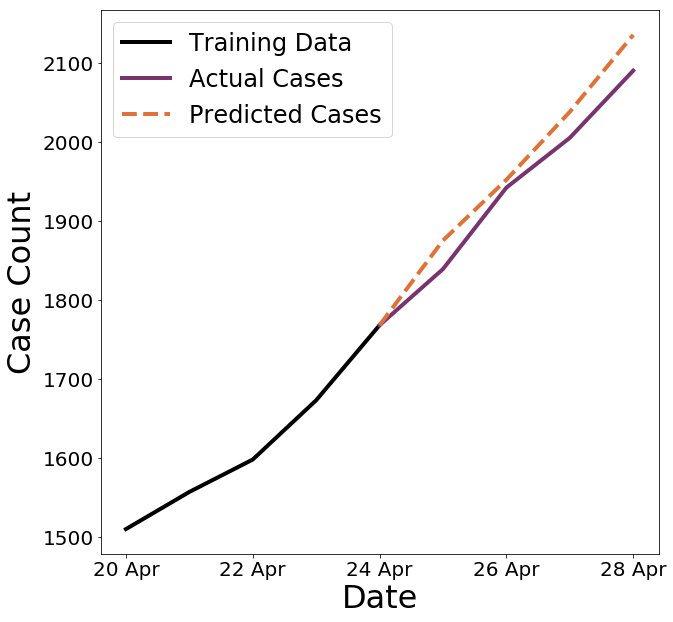

In [541]:
observed_values = sequences_test[start_index:end_index]
observed_values = observed_values[0,:,0]

plt.plot(range(sequence_length),observed_values,c='k',label="Training Data",linewidth=4)
plt.plot(range(sequence_length-1,sequence_length-start_index+end_index),[observed_values[-1]]+list(targets_test[start_index:end_index]),c=(0.4706, 0.2039, 0.4235),label="Actual Cases",linewidth=4)
plt.plot(range(sequence_length-1,sequence_length-start_index+end_index),[observed_values[-1]]+predictions,c=(0.8706, 0.451, 0.2235),label="Predicted Cases",linewidth=4,linestyle='--')

plt.xlabel("Date",size=32)
plt.ylabel("Case Count",size=32)
plt.xticks(size=20)
plt.yticks(size=20)
plt.xticks([0,2,4,6,8],["20 Apr","22 Apr","24 Apr","26 Apr","28 Apr"])
plt.legend(loc='upper left',fontsize=24); 